In [55]:
import pandas_ta as ta
import pandas as pd
import numpy as np
from datetime import datetime
import main_functions
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
# from lightweight_charts import Chart
# from lightweight_charts.widgets import JupyterChart
# import mplfinance as mpf
# import yfinance as yf

In [56]:
import importlib
# If you want to update the module:
importlib.reload(main_functions)
from main_functions import *

In [57]:
# exchange = krakenActive(mode, context='console')

In [58]:
# Initialize notebook mode
init_notebook_mode(connected=True)

In [59]:
pd.set_option('display.max_rows', 500)  # Set the maximum number of rows to display
pd.set_option('display.max_columns', 40) 

# Defining the variables

In [60]:
ticker = "BTCUSDT"
timeframe = "1d"
start = "2019-09-08"
start_date = datetime.strptime(start, "%Y-%m-%d")
end = str(datetime.now())
# Calculate the difference in days
day = (datetime.now() - start_date).days
direction = 'Both' # other options for direction 'Long' or 'Short'

In [61]:
max_sw_cnt_l = 3
max_sw_cnt_s = 3

In [62]:
df = getdata(ticker, timeframe, day)

In [90]:
def calculate_gann_signals(df, max_sw_cnt = 3, exit_perc = 80/100):
    calculate_candle_type(df)
    # Initialize p_cnt with a list containing the initial value (0) for the first row
    p_cnt_values = [0]

    # Iterate over the rows of the DataFrame starting from the second row (index 1)
    for i in range(1, len(df)):
        # Get the current candlestick type for the current row
        current_candle_type = df['candle_type'].iloc[i]

        # Get the previous sw_cnt value (p_cnt) for the current row
        previous_sw_cnt = p_cnt_values[i - 1]

        # Initialize a variable to store the new sw_cnt value
        new_sw_cnt = None

        # Check various conditions to determine the new sw_cnt value
        if (current_candle_type == "up_bar" and previous_sw_cnt < 0) or (current_candle_type == "outside_dn_up" and previous_sw_cnt < 0):
            new_sw_cnt = 1
        elif current_candle_type == "up_bar" and previous_sw_cnt < max_sw_cnt:
            new_sw_cnt = previous_sw_cnt + 1
        elif current_candle_type == "up_bar" and previous_sw_cnt == max_sw_cnt:
            new_sw_cnt = max_sw_cnt
        elif (current_candle_type == "down_bar" and previous_sw_cnt > 0) or (current_candle_type == "outside_up_dn" and previous_sw_cnt > 0):
            new_sw_cnt = -1
        elif current_candle_type == "down_bar" and previous_sw_cnt > -max_sw_cnt:
            new_sw_cnt = previous_sw_cnt - 1
        elif current_candle_type == "down_bar" and previous_sw_cnt == -max_sw_cnt:
            new_sw_cnt = -max_sw_cnt
        elif current_candle_type == "outside_dn_up" and previous_sw_cnt > 0:
            new_sw_cnt = previous_sw_cnt
        elif current_candle_type == "outside_up_dn" and previous_sw_cnt < 0:
            new_sw_cnt = previous_sw_cnt
        else:
            # If none of the conditions are met, keep the sw_cnt unchanged
            new_sw_cnt = previous_sw_cnt

        # Append the new sw_cnt value to the list of sw_cnt values
        p_cnt_values.append(new_sw_cnt)

    # Check if the length of sw_cnt values matches the number of rows in df
    if len(p_cnt_values) == len(df):
        # Assign the list of sw_cnt values to a new column 'sw_cnt' in df
        df['sw_cnt'] = p_cnt_values
    else:
        print("Length mismatch error between p_cnt_values and df.")

    # Initialize sw_trend with NaN
    df['sw_trend'] = np.nan

    # Create mask1 and mask2
    mask1 = (
        ((df['sw_cnt'] == -(max_sw_cnt)) |
         ((df['sw_cnt'] == 1) & (df['candle_type'] == 'outside_dn_up'))) &
        (df['sw_cnt'].shift(1) == -(max_sw_cnt-1))  # & (df['sw_trend'].shift(1) != df['sw_trend'])
    )

    mask2 = (
        ((df['sw_cnt'] == (max_sw_cnt)) |
         ((df['sw_cnt'] == -1) & (df['candle_type'] == 'outside_up_dn'))) &
        (df['sw_cnt'].shift(1) == (max_sw_cnt-1))  # & (df['sw_trend'].shift(1) != df['sw_trend'])
    )

    # Update sw_trend based on mask1 and mask2
    df.loc[mask1, 'sw_trend'] = -1
    df.loc[mask2, 'sw_trend'] = 1

    # Forward fill the sw_trend column to carry forward the last value
    df['sw_trend'].ffill(inplace=True)

    trend_cnt = [0]

    # Loop through the DataFrame index
    for i in range(1, len(df)):
        if df['sw_trend'].iloc[i - 1] == df['sw_trend'].iloc[i]:
            trend_cnt.append(trend_cnt[i - 1] + 1)
        else:
            trend_cnt.append(1)
    # Append a 0 at the beginning to match the length of the DataFrame
    trend_cnt.insert(0, 0)

    df['trend_cnt'] = trend_cnt[:-1]

    # Initialize sw_top column with False
    df['sw_top'] = False
    df['sw_bottom'] = False

    # Calculate the maximum High value of past n candles when mask1 is true
    for i in range(len(df)):
        if mask1[i] & (df['sw_trend'].iloc[i - 1] != df['sw_trend'].iloc[i]):
            # Calculate the maximum High and its index
            high_range = df.loc[
                df.index[max(0, i - int(df['trend_cnt'][i]))]:df.index[i]]['High']
            max_high = high_range.max()
            max_high_index = high_range.idxmax()

            # Mark the row where max_high occurs as True
            df.at[max_high_index, 'sw_top'] = True

        elif mask2[i] & (df['sw_trend'].iloc[i - 1] != df['sw_trend'].iloc[i]):
            # Calculate the maximum High and its index
            low_range = df.loc[
                df.index[max(0, i - int(df['trend_cnt'][i]))]:df.index[i]]['Low']
            min_low = low_range.min()
            min_low_index = low_range.idxmin()

            # Mark the row where max_high occurs as True
            df.at[min_low_index, 'sw_bottom'] = True

    df['sw_high_price'] = np.where(
        df['sw_top'] == True, df['High'], np.nan)
    df['sw_high_price'].fillna(method='ffill', inplace=True)
    df['sw_low_price'] = np.where(
        df['sw_bottom'] == True, df['Low'], np.nan)
    df['sw_low_price'].fillna(method='ffill', inplace=True)

    # Filter rows where sw_top is True and calculate sw_highs
    df_tops = df[df['sw_top'] == True].copy()
    df_tops['sw_highs'] = np.where(
        df_tops['High'] > df_tops['High'].shift(1), "HH", "LH")

    # Filter rows where sw_bottom is True and calculate sw_lows
    df_bottoms = df[df['sw_bottom'] == True].copy()
    df_bottoms['sw_lows'] = np.where(
        df_bottoms['Low'] < df_bottoms['Low'].shift(1), "LL", "HL")

    # Concatenate the DataFrames and select the desired columns
    df_swings = pd.concat([df_tops, df_bottoms], axis=1)

    df_swings['trend'] = np.nan
    df_swings['trend'] = np.where(((df_swings['sw_highs'] == 'HH') & (df_swings['sw_lows'].shift(1) == 'HL')) |
                                  ((df_swings['sw_lows'] == 'HL') & (df_swings['sw_highs'].shift(1) == 'HH')),
                                   "UP",
                                   np.where(((df_swings['sw_lows'] == 'LL') & (df_swings['sw_highs'].shift(1) == 'LH')) |
                                            ((df_swings['sw_highs'] == 'LH') & (df_swings['sw_lows'].shift(1) == 'LL')),
                                            "DOWN",
                                            np.where(((df_swings['sw_lows'] == 'LL') & (df_swings['sw_highs'].shift(1) == 'HL')) |
                                                     ((df_swings['sw_lows'] == 'LL') & (df_swings['sw_highs'].shift(1) == 'HH')) |
                                                     ((df_swings['sw_lows'] == 'HL') & (df_swings['sw_highs'].shift(1) == 'LH')) |
                                                     ((df_swings['sw_highs'] == 'LH') & (df_swings['sw_lows'].shift(1) == 'HL')) |
                                                     ((df_swings['sw_highs'] == 'HH') & (df_swings['sw_lows'].shift(1) == 'LL')),
                                                     "UNCERTAIN",
                                                     np.nan
                                                    )
                                                 )
                                             )


    df_swings = df_swings[["sw_highs", "sw_lows", "trend"]]

    df_ffill = pd.concat([df, df_swings], axis=1)

    # Define the columns to be copied
    columns_to_copy = ["sw_highs", "sw_lows", "trend"]

    # Forward fill columns in df_ffill
    df_ffill[columns_to_copy] = df_ffill[columns_to_copy].fillna(method='ffill')

    # Drop the columns to be replaced from df
    for column in columns_to_copy:
        if column in df.columns:
            df.drop(columns=column, inplace=True)

    # Update the original DataFrame with the filled columns
    df = pd.concat([df, df_ffill[columns_to_copy]], axis=1)

    df['trend'] = np.where(
                            ((df['sw_lows'] == 'HL') & (df['High'] > df['sw_high_price'])),
                               "UP",
                               np.where(((df['sw_highs'] == 'LH') & (df['Low'] < df['sw_low_price'])),
                                        "DOWN",
                                        df['trend']
                                       )
                            )
    # df['trend'].fillna(method='ffill', inplace=True)

    df['tsl_long'] = df['sw_low_price'].shift(1)
    df['tsl_short'] = df['sw_high_price'].shift(1)

    df["LONG_Signal"] = np.where(
        ((df['sw_lows'] == "HL") | ((df['sw_highs'] == "HH") & (df['sw_lows'] == "HL"))) & 
        ((df['High'] > df['sw_high_price'].shift(1)) &
        (df['High'].shift(1) < df['sw_high_price'].shift(1)) &
        ((df['trend'].shift(1) == "UNCERTAIN") | (df['trend'] == "UP"))),
        True,
        False
    )

    df["SHORT_Signal"] = np.where(
        ((df['sw_highs'] == "LH") | ((df['sw_lows'] == "LL") & (df['sw_highs'] == "LH"))) & 
        (df['Low'] < df['sw_low_price'].shift(1)) &
        (df['Low'].shift(1) > df['sw_low_price'].shift(1)) &
        ((df['trend'].shift(1) == "UNCERTAIN") | (df['trend'] == "DOWN")),  
        True, 
        False
    )

    exit_perc = 80/100 # Percentage for limit order price price calculation --- > streamlit input

    df["Long_Exit"] = np.where((df['sw_highs'] == "LH") & 
                            (df['sw_trend'].shift(1) == 1.0) &
                            (df['sw_trend'] == -1.0) &
                            (df['trend'] == "UNCERTAIN"),  
                            ((df['sw_high_price'] - df['sw_low_price'])*exit_perc + df['sw_low_price']), 
                                np.nan)

    df["Short_Exit"] = np.where((df['sw_lows'] == "HL") & 
                            (df['sw_trend'].shift(1) == -1.0) &
                            (df['sw_trend'] == 1.0) &
                            (df['trend'] == "UNCERTAIN"),  
                            (df['sw_high_price'] - (df['sw_high_price'] - df['sw_low_price'])*exit_perc), 
                                np.nan)
    
    df["pi_top"] = np.where(
                            (df['Open'].rolling(window=111).mean()) > (df['Open'].rolling(window=350).mean() * 2), 
                            True, 
                            False
                            )
    
    df["pi_bottom"] = np.where(
                            (df['Close'].rolling(window=550).mean() > df['Close'].rolling(window=250).mean()), 
                            True, 
                            False
                            )
    
    st.write(df[300:500])
    
    return df

def backtest(df, ticker, direction="Both", commission=0.04/100, tp_perc=0, pi_exit = True):
    in_position = False
    buy_pos = False
    sell_pos = False

    results_df = pd.DataFrame()
    buydates, buyprices = [], []
    selldates, sellprices = [], []

    for index, row in df.iterrows():
    # ---------------------------------------------long position close check------------------------------
        if in_position and buy_pos:
            
            sl = row.tsl_long
            if (row.Low <= sl):
                selldates.append(index)
                sellprices.append(row.Low)
                in_position = False
                buy_pos = False
            elif (row.High >= tp) and (tp_perc != 0):
                selldates.append(index)
                sellprices.append(row.High)
                in_position = False
                buy_pos = False
            elif (row.pi_top) and (pi_exit):
                selldates.append(index)
                sellprices.append(row.High)
                in_position = False
                buy_pos = False
            elif row.Long_Exit > 0:
                limit = row.Long_Exit
            elif row.Low <= limit:
                selldates.append(index)
                sellprices.append(limit)
                in_position = False
                buy_pos = False

    # ---------------------------------------------short position close check------------------------------
        elif in_position and sell_pos:
            sl = row.tsl_short
            if (row.High >= sl):
                buydates.append(index)
                buyprices.append(row.High)
                in_position = False
                sell_pos = False
                
            elif (row.Low <= tp) and (tp_perc != 0):
                buydates.append(index)
                buyprices.append(row.Low)
                in_position = False
                buy_pos = False
            elif (row.pi_bottom) and (pi_exit):
                buydates.append(index)
                buyprices.append(row.Low)
                in_position = False
                buy_pos = False
            elif row.Short_Exit > 0:
                limit = row.Short_Exit
            elif row.High >= limit:
                buydates.append(index)
                buyprices.append(limit)
                in_position = False
                buy_pos = False
                
    #         print(limit, in_position)
                
    # ======================================================================================================              
                
    # ---------------------------------------------long position entry check------------------------------
        if not in_position:
            if direction in ("Both", "Long") and row.LONG_Signal:
                buyprice = row.tsl_short
                buydates.append(index)
                buyprices.append(buyprice)
                in_position = True
                buy_pos = True
                tp = buyprice * (1 + tp_perc)
                limit = np.nan

            elif direction in ("Both", "Short") and row.SHORT_Signal:
                sellprice = row.tsl_long
                selldates.append(index)
                sellprices.append(sellprice)
                in_position = True
                sell_pos = True
                tp = sellprice * (1 - tp_perc)
                limit = np.nan

                    

    if len(buydates) == 0:
        print(f"No trades were made for {ticker}.")
    else:
        profits = [(sell - buy) / buy - commission for sell, buy in zip(sellprices, buyprices)]
        returns = ((pd.Series(profits, dtype=float) + 1).prod() - 1) * 100
        wins = 0
        for i in profits:
            if i > 0:
                wins += 1
            i += 1
        winrate = round((wins / len(buydates)) * 100, 2)
        ct = min(len(buydates), len(selldates))

        # BTCUSDT buy and hold returns during the same period
        buy_hold_ret = (df['Close'][-1] - df['Open'][0]) / df['Open'][0] * 100

        results_df = pd.concat([results_df, pd.DataFrame({'ticker': f'{ticker}', 'returns': [returns], 'winrate': [winrate], 'trades': [ct], 'buy&hold_ret%': [buy_hold_ret]})])
        st.subheader('Backtest Results')
        st.write(f'{ticker}, winrate={winrate}%, returns={round(returns, 2)}%, no. of trades = {ct}, buy&hold_ret = {round(buy_hold_ret, 2)}%')

    # Return the trade data along with other results
    return {
        'buydates': buydates,
        'buyprices': buyprices,
        'selldates': selldates,
        'sellprices': sellprices,
        'profits': profits,
        # Other results...
    }, results_df

In [91]:
df = calculate_gann_signals(df, max_sw_cnt = 3, exit_perc = 80/100)

In [93]:
df[200:500]

,Open,High,Low,Close,Volume,candle_type,sw_cnt,sw_trend,trend_cnt,sw_top,sw_bottom,sw_high_price,sw_low_price,tsl_long,tsl_short,LONG_Signal,SHORT_Signal,Long_Exit,Short_Exit,pi_top,pi_bottom,sw_highs,sw_lows,trend
timestamp,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-26,6673.57,6777.50,6500.00,6733.76,281245.628,,3,1.0,6,False,False,6960.71,3621.81,3621.81,6960.71,False,False,NaN,NaN,False,False,LH,LL,DOWN
2020-03-27,6733.76,6840.00,6230.00,6353.64,258213.519,outside_up_dn,-1,1.0,7,False,False,6960.71,3621.81,3621.81,6960.71,False,False,NaN,NaN,False,False,LH,LL,DOWN
2020-03-28,6353.64,6354.74,6004.00,6230.95,341944.185,down_bar,-2,1.0,8,False,False,6960.71,3621.81,3621.81,6960.71,False,False,NaN,NaN,False,False,LH,LL,DOWN
2020-03-29,6231.81,6260.00,5857.60,5876.27,251335.919,down_bar,-3,-1.0,9,False,False,6960.71,3621.81,3621.81,6960.71,False,False,NaN,NaN,False,False,LH,LL,DOWN
2020-03-30,5876.27,6606.15,5850.00,6391.08,387321.998,outside_dn_up,1,-1.0,1,False,True,6960.71,5850.00,3621.81,6960.71,False,False,NaN,NaN,False,False,LH,HL,UNCERTAIN
2020-03-31,6389.52,6516.63,6320.00,6407.10,262522.644,,1,-1.0,2,False,False,6960.71,5850.00,5850.00,6960.71,False,False,NaN,NaN,False,False,LH,HL,UNCERTAIN
2020-04-01,6407.10,6693.00,6140.00,6641.51,390529.602,outside_dn_up,1,-1.0,3,False,False,6960.71,5850.00,5850.00,6960.71,False,False,NaN,NaN,False,False,LH,HL,UNCERTAIN
2020-04-02,6641.22,7290.00,6542.73,6791.63,531321.428,up_bar,2,-1.0,4,False,False,6960.71,5850.00,5850.00,6960.71,True,False,NaN,NaN,False,False,LH,HL,UP
2020-04-03,6791.65,7049.11,6600.00,6729.80,411944.927,,2,-1.0,5,False,False,6960.71,5850.00,5850.00,6960.71,False,False,NaN,NaN,False,False,LH,HL,UP


# Backtest

In [94]:
tp_exit = False  #----> streamlit input
tp_value = 38/100 #----> streamlit input
tp_perc = 0 if tp_exit == False else tp_value
direction = "Both"
pi_exit = True

In [95]:
# Trades Display

# def displayTrades():
#     ct = min(len(buydates),len(selldates))
#     dfr =pd.DataFrame()
#     dfr['buydates']= buydates[:ct]
#     dfr['buyprice']= buyprices[:ct]
#     dfr['selldates'] = selldates[:ct]
#     dfr['sellprice'] = sellprices[:ct]
#     dfr['profits'] = (profits[:ct])
#     dfr['commulative_returns'] = ((pd.Series(profits) + 1).cumprod())
#     dfr['tradeSide'] = np.where(dfr['buydates'] < dfr['selldates'], 'Long', 'Short')
#     return dfr
def displayTrades(direction="Both", **kwargs):
    st.write('Direction: ', direction)
    # Access the trade data and other results from kwargs
    buydates = kwargs['buydates']
    buyprices = kwargs['buyprices']
    selldates = kwargs['selldates']
    sellprices = kwargs['sellprices']
    profits = kwargs['profits']

    ct = min(len(buydates), len(selldates))
    
    # Create a DataFrame to store the trades
    dfr = pd.DataFrame()
    dfr['buydates'] = buydates[:ct]
    dfr['buyprice'] = buyprices[:ct]
    dfr['selldates'] = selldates[:ct]
    dfr['sellprice'] = sellprices[:ct]
    dfr['profits'] = (profits[:ct])
    dfr['commulative_returns'] = ((pd.Series(profits) + 1).cumprod())
    
    # Filter trades based on the selected direction
#     if direction == "Both":
#         pass  # Keep all trades
#     elif direction == "Long":
#         dfr = dfr[dfr['buydates'] < dfr['selldates']]
#     elif direction == "Short":
#         dfr = dfr[dfr['buydates'] > dfr['selldates']]
    
    # Add a column to indicate the trade side
    dfr['tradeSide'] = np.where(dfr['buydates'] < dfr['selldates'], 'Long', 'Short')
    
    return dfr


In [96]:
results_data, result_df = backtest(df, ticker, direction="Both", commission=0.04/100, tp_perc=tp_perc, pi_exit = pi_exit)

In [97]:
result_df

,ticker,returns,winrate,trades,buy&hold_ret%
0,BTCUSDT,814.631673,56.52,22,178.753


In [98]:
dfr = displayTrades(direction="Both", **results_data)
dfr

,buydates,buyprice,selldates,sellprice,profits,commulative_returns,tradeSide
0,2019-10-25,8800.00,2019-10-23,7700.67,-0.125324,0.874676,Short
1,2020-01-06,7691.00,2020-03-08,7997.70,0.039478,0.909206,Long
2,2020-04-02,7290.00,2020-03-08,8409.00,0.153098,1.048404,Short
3,2020-04-02,6960.71,2020-07-13,9339.28,0.341314,1.406239,Long
4,2020-07-22,9470.00,2020-09-03,9901.16,0.045129,1.469701,Long
5,2020-10-10,11494.00,2020-09-03,11130.00,-0.032069,1.422570,Short
6,2020-10-10,11177.00,2021-04-13,63850.00,4.712224,8.126036,Long
7,2021-04-13,61950.00,2021-04-14,64986.11,0.048609,8.521035,Long
8,2021-06-14,41000.00,2021-05-13,46930.43,0.144245,9.750148,Short
9,2021-06-14,39470.00,2021-06-22,28780.01,-0.271238,7.105534,Long


## CANDLES CHART

In [77]:
plot_advanced_gann_swing_chart(df, dfr, visible_data_points=1500)

In [ ]:
styled_df = df.copy()
styled_df.reset_index(inplace = True)
# Define custom CSS to make the header row sticky
css = [
    {
        'selector': 'thead tr',
        'props': 'position: sticky; top: 0; background-color: white;'
    }
]

# Apply the custom CSS to the DataFrame
styled_df = styled_df.style.set_table_styles(css)

# Display the styled DataFrame
styled_df

In [102]:
# if __name__ == '__main__':
#     # chart = Chart()
#     # Create a JupyterChart instance
#     chart = JupyterChart()
#     chart.layout(background_color='#090008', text_color='#FFFFFF', font_size=16, font_family='Helvetica')

# chart.candle_style(up_color='#00ff55', down_color='#ed4807', border_up_color='#FFFFFF', border_down_color='#FFFFFF',
#                    wick_up_color='#FFFFFF', wick_down_color='#FFFFFF')

# chart.volume_config(up_color='#00ff55', down_color='#ed4807')

# chart.watermark('1D', color='rgba(180, 180, 240, 0.7)')

# chart.crosshair(mode='normal', vert_color='#FFFFFF', vert_style='dotted', horz_color='#FFFFFF', horz_style='dotted')

# chart.legend(visible=True, font_size=14)

# # Assuming your DataFrame is 'df' and has the required columns
# chart.set(df)

# chart.load()

In [ ]:
# def backtest(df_, **kwargs):
    
#     df = getSignals(df_, **kwargs)
#     # Extract the parameter values from the kwargs dictionary
#     mult = kwargs.get('mult', 1)
#     HL = kwargs.get('HL', 20)
#     risk = kwargs.get('risk', 15)
    
#     in_position = False
#     buy_pos = False
#     sell_pos = False
    
#     global buydates, buyprices, selldates, sellprices, profits
#     global results_df
#     results_df = pd.DataFrame()
#     buydates, buyprices = [],[]
#     selldates, sellprices = [],[]

#     for index,row in df.iterrows():
#     # long position block
#         if not in_position and row.buySignal == 1:
#             buyprice = row.shifted_open
#             buydates.append(index)
#             buyprices.append(buyprice)
#             in_position = True
#             buy_pos = True
#             sl = row.MinLow
#             tp = row.longTP
#         elif in_position and buy_pos:
#             if (row.Low <= sl):
#                 selldates.append(index)
#                 sellprices.append(sl)
#                 in_position = False
#                 buy_pos = False
#             elif in_position and (row.High >= tp):
#                 selldates.append(index)
#                 sellprices.append(tp)
#                 in_position = False
#                 buy_pos = False

#     # short position block
#         elif not in_position and row.shortSignal == -1:
#             sellprice = row.shifted_open
#             selldates.append(index)
#             sellprices.append(sellprice)
#             in_position = True
#             sell_pos = True
#             sl = row.MaxHigh
#             tp = row.shortTP
#         else:
#             if in_position and sell_pos and (row.High >= sl):
#                 buydates.append(index)
#                 buyprices.append(sl)
#                 in_position = False
#                 sell_pos = False
#             elif in_position and (row.Low <= tp):
#                 buydates.append(index)
#                 buyprices.append(tp)
#                 in_position = False
#                 sell_pos = False


#     try:
#         if len(buydates) == 0:
#             print("No trades were made.")
#         else:
#             profits = [(sell - buy)/buy - commission for sell,buy in zip(sellprices, buyprices)]
#             returns = ((pd.Series(profits, dtype=float) + 1).prod()-1)*100
#             wins = 0
#             for i in profits:
#                 if i > 0:
#                     wins+=1
#                 i+=1
#             winrate = round((wins/len(buydates))*100,2)
#             ct = min(len(buydates),len(selldates))
#             # BTCUSDT buy and hold returns during the same period

#             buy_hold_ret = (df['Close'][-1]-df['Open'][0])/df['Open'][0] *100
#             results_df = pd.concat([results_df, pd.DataFrame({'ticker': f'{ticker}', 'returns': [returns], 'winrate': [winrate], 'trades':[ct], 'buy&hold_ret%' : [buy_hold_ret], 'mult' : [mult], 'No. of H/L previous Candles':[HL], 'Max Risk%':[risk]})])
#             print(f'{ticker}, winrate={winrate}%, returns={round(returns,2)}%, no. of trades = {ct}, buy&hold_ret = {round(buy_hold_ret,2)}%, mult = {mult}, No. of H/L previous Candles : {HL}, Max Risk% : {risk}')
#     except:
#         print(f'Invalid input')
        
#     return results_df['returns']

backtest(df)

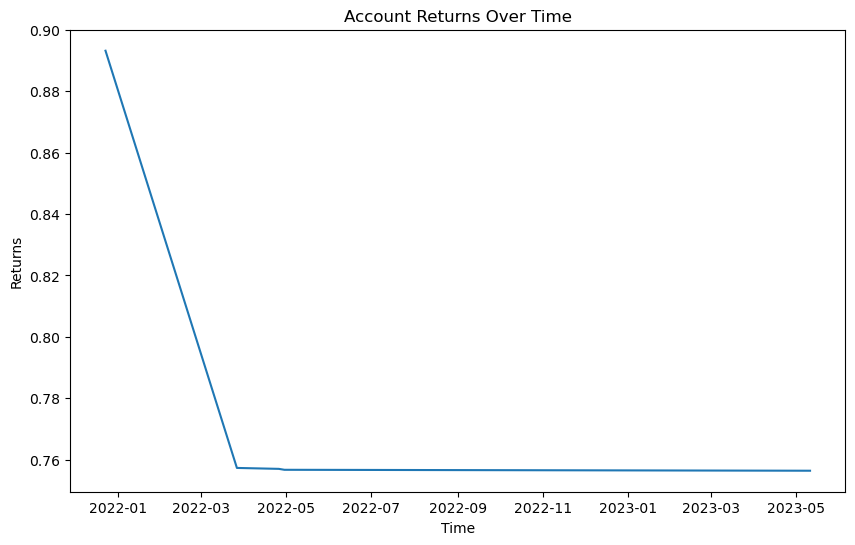

In [61]:
import matplotlib.pyplot as plt

# Set the plot size
plt.figure(figsize=(10,6))

# Plot the account balance column
plt.plot(dfr.buydates, dfr.commulative_returns)

# Add labels to the plot
plt.title('Account Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Returns')

# Display the plot
plt.show()

# Set Final Bot Parameters

In [20]:
# please put this bot parameters here

ticker = "BTCUSDT"
timeframe = "15m"
usdt_amount = 15

takeLong = True 
takeShort = True

mult = 1 # TP R:R MULTIPLYER                           ----> TO BE OPTIMIZED
risk = 15.0 # IF STOPLOSS > ?%  DONT ENTER!            ----> TO BE OPTIMIZED
HL = 20 # rolling high lows                            ----> TO BE OPTIMIZED